<a href="https://colab.research.google.com/github/uginm102/MCSC-MUK/blob/main/MCS%207224%20Computer%20Vision/Assignment%203/MCS_7224_Computer_Vision_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparative Analysis of Feature Extraction and Machine Learning Models for Image Classification - Detecting Groundnut leaf spot
Groundnut leaf spot, also known as Tikka disease, is a serious fungal disease impacting groundnut crops, primarily caused by Cercospora arachidicola (early leaf spot) and Phaeoisariopsis personata (late leaf spot), leading to defoliation and reduced yield

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.feature import hog
from skimage import exposure
from skimage.feature import local_binary_pattern
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,auc, confusion_matrix, ConfusionMatrixDisplay
import os
import random

try:
  import mahotas
except:
  !pip install mahotas
  import mahotas

try:
  from tensorflow.keras.applications import VGG16
  from tensorflow.keras.layers import GlobalAveragePooling2D
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
  from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
  from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from tensorflow.keras.applications import ResNet50
except:
  !pip install tensorflow
  from tensorflow.keras.applications import VGG16
  from tensorflow.keras.layers import GlobalAveragePooling2D
  from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
  from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from tensorflow.keras.applications import ResNet50


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
diseased_images = glob('/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/model/images/train/Diseased/*.jpg')
healthy_images = glob('/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/model/images/train/Healthy/*.jpg')

image_files_path = [f for f in diseased_images + healthy_images]

##Exploratory Data Analysis (EDA)

Diseased: 158, Healthy: 158


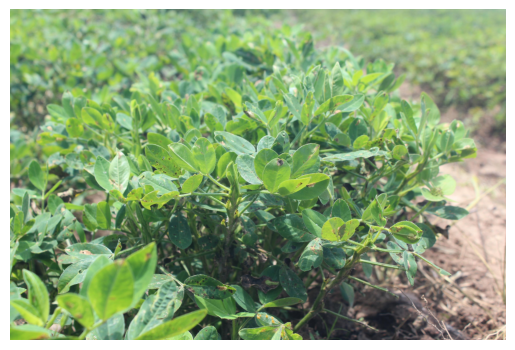

In [4]:
print(f"Diseased: {len(diseased_images)}, Healthy: {len(diseased_images)}")

image_path = diseased_images[11]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()


##Feature Extraction

###Traditional Feature Extraction

####Scale-Invariant Feature Transform (SIFT)

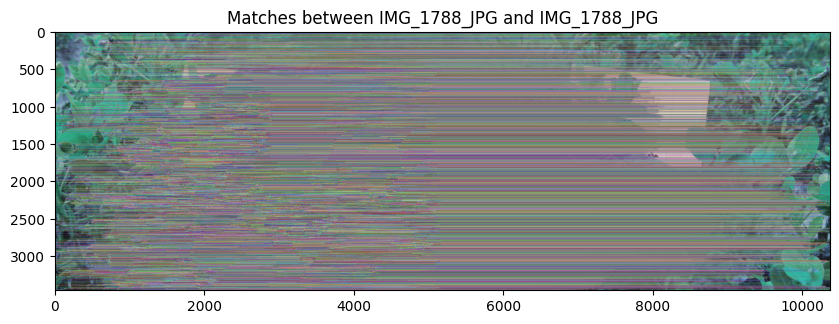

Found 33419 good matches between IMG_1788_JPG and IMG_1788_JPG


In [31]:
sift = cv2.SIFT_create()

# Dictionary to store keypoints and descriptors
image_features = {}

# Detect keypoints and compute descriptors for 10 random images
for img_path in random.choices(image_files_path, k=10):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {img_path}")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    # TODO make sure split works.
    image_name = img_path.split("/")[15].split(".")[0]
    # Store results
    image_features[image_name] = {
        "keypoints": keypoints,
        "descriptors": descriptors,
        "image": img
    }
    #print(f"Processed {image_name}: {len(keypoints)} keypoints detected")

# Match features between pairs of images (example: first two images)
if len(image_features) >= 2:
  # keys = list(prices)
  img1_name = next(iter(image_features))
  img2_name = next(iter(image_features))
  # img1_name, img2_name = image_files_path[0].split("/")[15].split(".")[0], image_files_path[1].split("/")[15].split(".")[0]
  kp1 = image_features[img1_name]["keypoints"]
  desc1 = image_features[img1_name]["descriptors"]
  kp2 = image_features[img2_name]["keypoints"]
  desc2 = image_features[img2_name]["descriptors"]

  # Use BFMatcher (Brute-Force Matcher) to match descriptors
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.knnMatch(desc1, desc2, k=2)

  # Apply ratio test
  good_matches = []
  for m, n in matches:
      if m.distance < 0.75 * n.distance:
          good_matches.append(m)

  # Draw matches
  img1 = image_features[img1_name]["image"]
  img2 = image_features[img2_name]["image"]
  matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  # Display the result
  plt.figure(figsize=(10, 5))
  plt.imshow(matched_img)
  plt.title(f"Matches between {img1_name} and {img2_name}")
  plt.show()

  print(f"Found {len(good_matches)} good matches between {img1_name} and {img2_name}")

####Histogram of Oriented Gradients (HOG)


Computed HOG for IMG_1781_JPG: descriptor length = 13455036


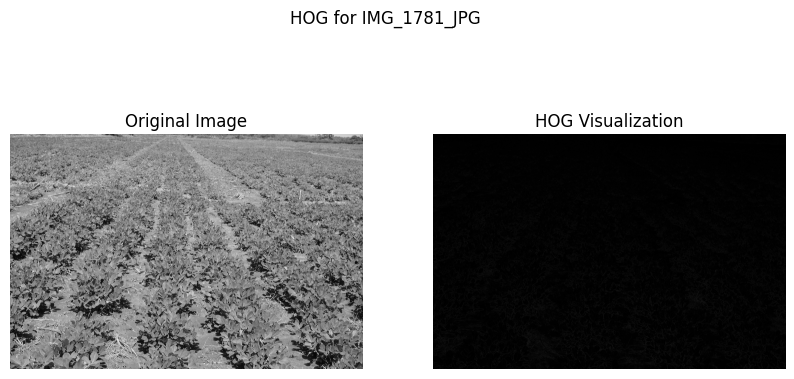

Computed HOG for IMG_1781_JPG: descriptor length = 4453092


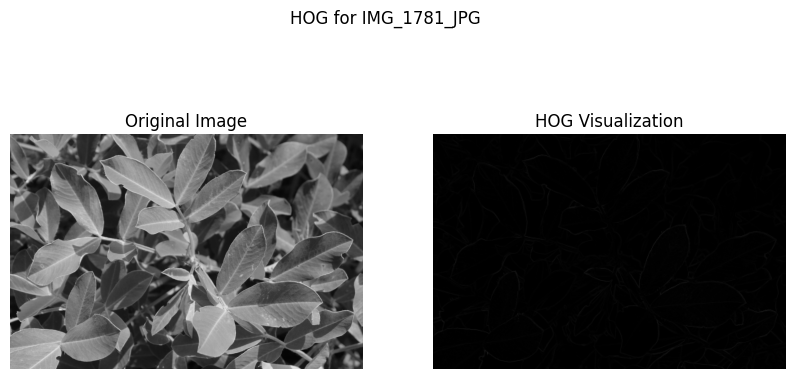

Computed HOG for IMG_1781_JPG: descriptor length = 4453092


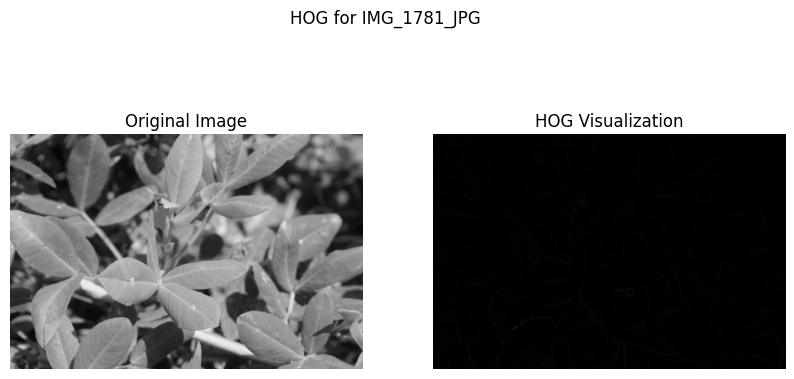

Computed HOG for IMG_1781_JPG: descriptor length = 13455036


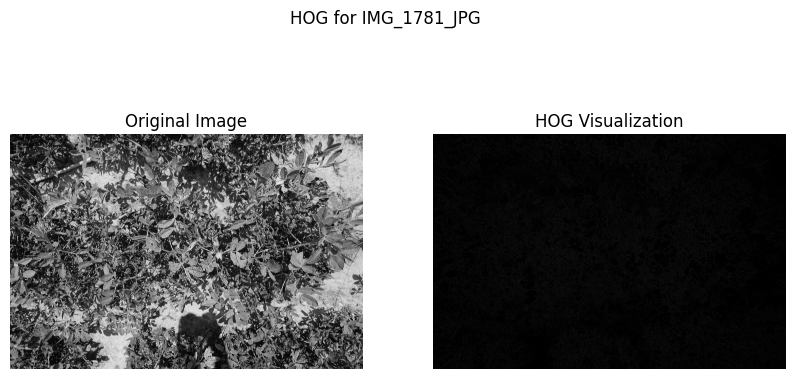

KeyboardInterrupt: 

In [32]:
# Parameters for HOG
pixels_per_cell = (8, 8)  # Size of each cell (in pixels)
cells_per_block = (2, 2)  # Number of cells per block
orientations = 9          # Number of orientation bins
visualize = True          # Whether to visualize HOG features

# List to store HOG descriptors
hog_descriptors = {}

# Compute HOG descriptors for 10 random images
for image_file_path in random.choices(image_files_path, k=10):
    img = cv2.imread(image_file_path)
    if img is None:
        print(f"Failed to load {img_path}")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize image (optional, adjust based on your needs)
    # gray = cv2.resize(gray, (128, 64))  # Example size for pedestrian detection

    # Compute HOG descriptors
    if visualize:
        # Also compute HOG image for visualization
        fd, hog_image = hog(
            gray,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=True,
            transform_sqrt=True  # Apply power law compression (recommended)
        )
    else:
        fd = hog(
            gray,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            visualize=False,
            transform_sqrt=True
        )

    # Store the descriptor
    image_name = img_path.split("/")[15].split(".")[0]
    hog_descriptors[image_name] = fd
    print(f"Computed HOG for {image_name}: descriptor length = {len(fd)}")

    # Visualize the HOG image
    if visualize:
        # Rescale HOG image for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        # Display original and HOG image side by side
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(gray, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(hog_image_rescaled, cmap='gray')
        plt.title('HOG Visualization')
        plt.axis('off')

        plt.suptitle(f"HOG for {image_name}")
        plt.show()

# Optional: Print the shape of descriptors for verification
for image_file, descriptor in random.choice(hog_descriptors.items(), k=10):
    print(f"{image_file}: HOG descriptor shape = {descriptor.shape}")

####Local Binary Patterns (LBP)

Computed LBP for DSC05933_JPG: histogram length = 26


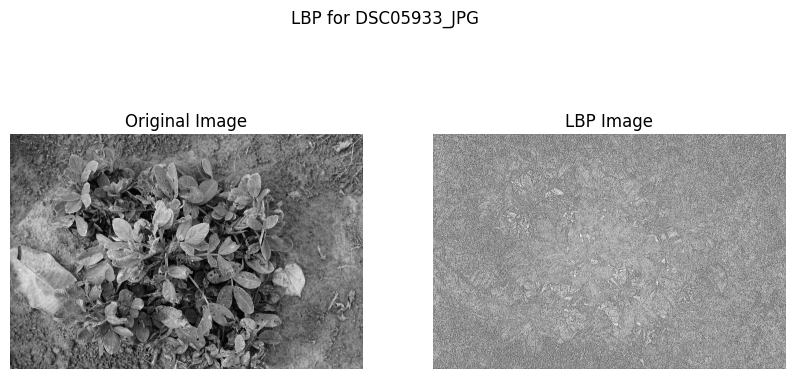

Computed LBP for DSC05714_JPG: histogram length = 26


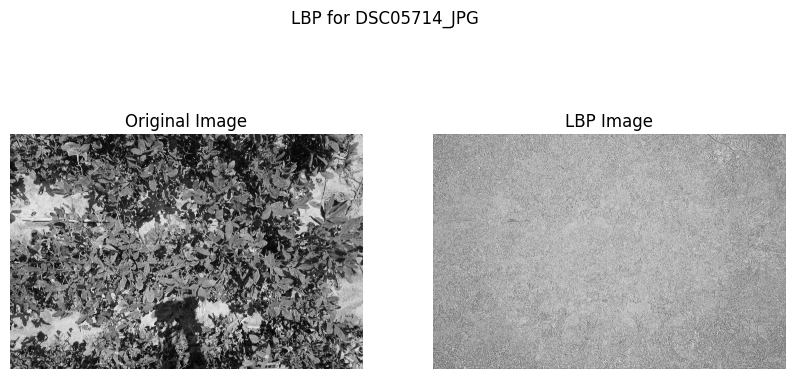

Computed LBP for IMG_1346_JPG: histogram length = 26


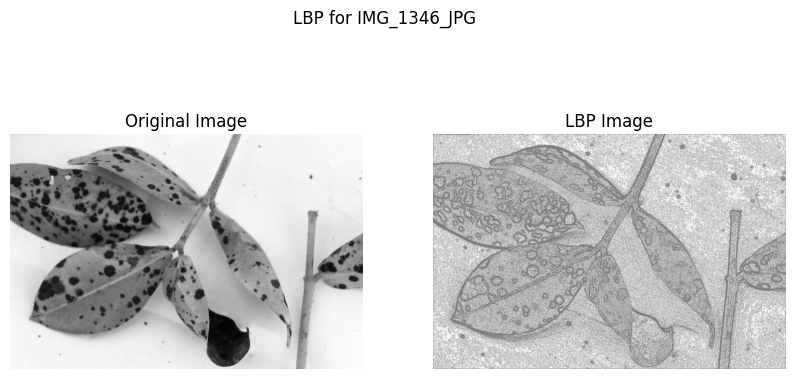

Computed LBP for DSC05845_JPG: histogram length = 26


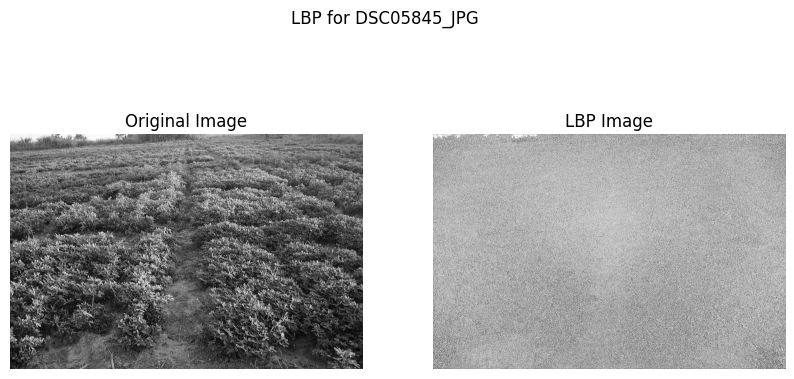

Computed LBP for IMG_1780_JPG: histogram length = 26


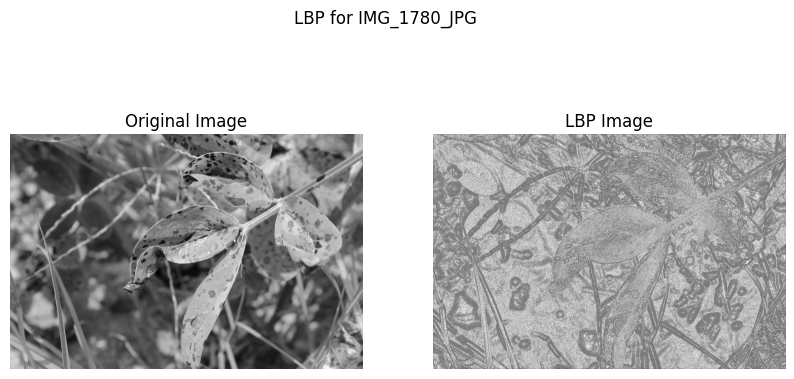

Computed LBP for DSC05711_JPG: histogram length = 26


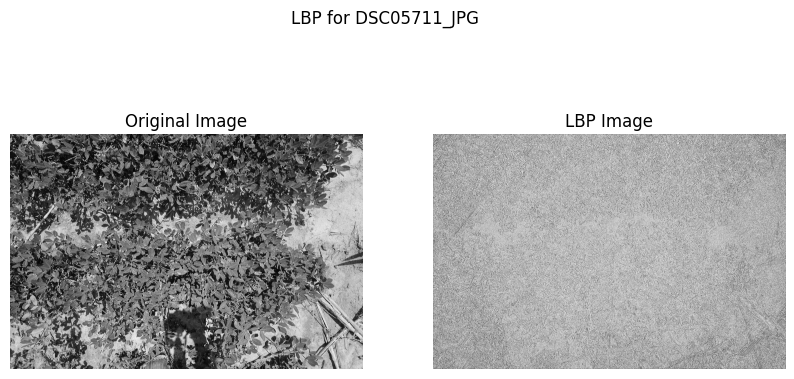

Computed LBP for DSC05657_JPG: histogram length = 26


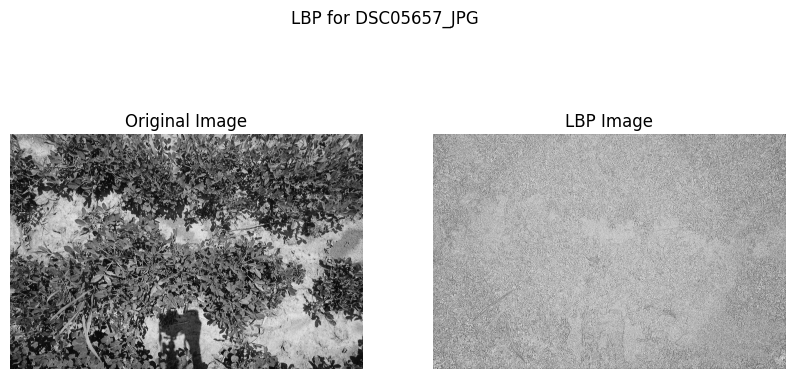

Computed LBP for DSC05753_JPG: histogram length = 26


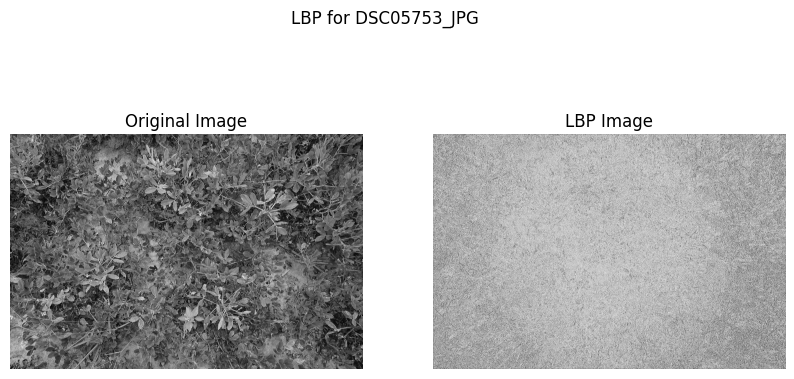

Computed LBP for IMG_6711_JPG: histogram length = 26


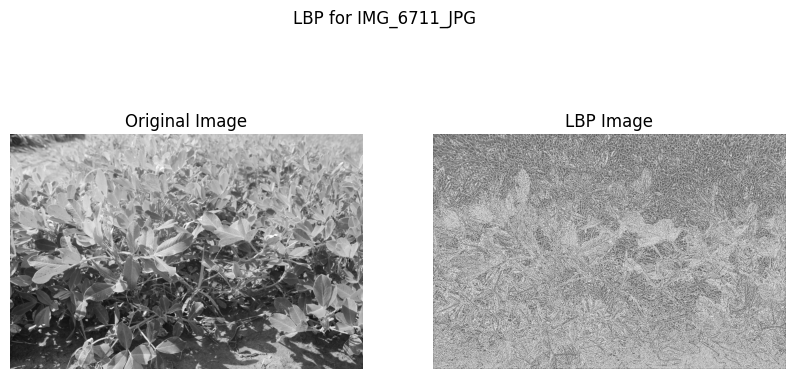

Computed LBP for IMG_8359_JPG: histogram length = 26


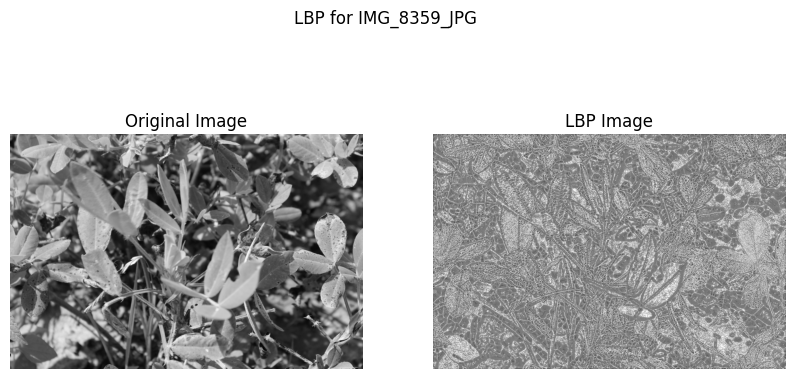

DSC05933_JPG: LBP histogram shape = (26,)
DSC05714_JPG: LBP histogram shape = (26,)
IMG_1346_JPG: LBP histogram shape = (26,)
DSC05845_JPG: LBP histogram shape = (26,)
IMG_1780_JPG: LBP histogram shape = (26,)
DSC05711_JPG: LBP histogram shape = (26,)
DSC05657_JPG: LBP histogram shape = (26,)
DSC05753_JPG: LBP histogram shape = (26,)
IMG_6711_JPG: LBP histogram shape = (26,)
IMG_8359_JPG: LBP histogram shape = (26,)


In [24]:
# LBP parameters
radius = 3          # Radius of the circle (defines the neighborhood)
n_points = 8 * radius  # Number of points to sample (8 * radius for a circular neighborhood)
method = 'uniform'  # 'uniform' for uniform patterns, 'default' for basic LBP, 'ror' for rotation-invariant

# List to store LBP histograms
lbp_histograms = {}

# Compute LBP and histograms for 10 sample image
for image_file_path in random.choices(image_files_path, k=10):
    # Load image
    # img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_file_path)
    if img is None:
        print(f"Failed to load {image_file_path}")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute LBP
    lbp = local_binary_pattern(gray, n_points, radius, method=method)

    # Compute histogram of LBP
    if method == 'uniform':
        # For uniform LBP, the number of bins is n_points + 2 (non-uniform patterns are grouped)
        n_bins = int(lbp.max() + 1)
    else:
        # For default LBP, use 2^number of points (e.g., 256 for 8 neighbors)
        n_bins = 2**n_points if method == 'default' else int(lbp.max() + 1)

    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Store the histogram
    image_name = image_file_path.split("/")[15].split(".")[0]
    lbp_histograms[image_name] = hist
    print(f"Computed LBP for {image_name}: histogram length = {len(hist)}")

    # Visualize the original image and LBP
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(lbp, cmap='gray')
    plt.title('LBP Image')
    plt.axis('off')

    plt.suptitle(f"LBP for {image_name}")
    plt.show()

# Print the shape of histograms for verification
for image_file, hist in lbp_histograms.items():
    print(f"{image_file}: LBP histogram shape = {hist.shape}")

####Color Histograms

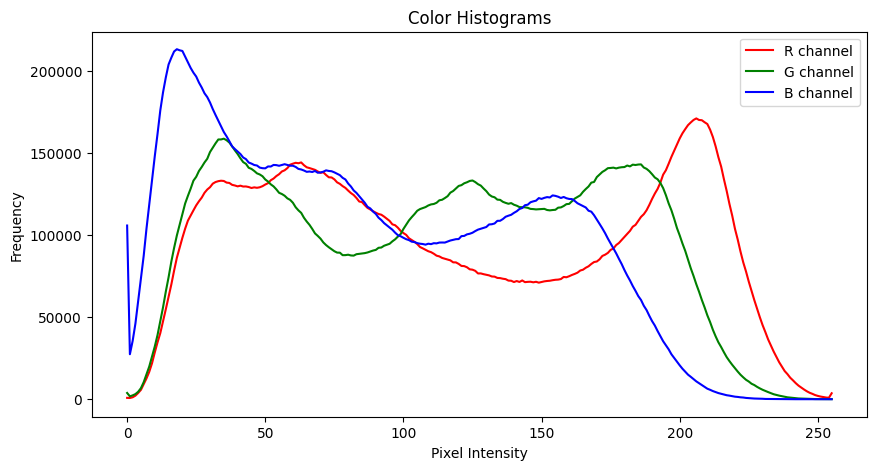

Feature size per channel: 256


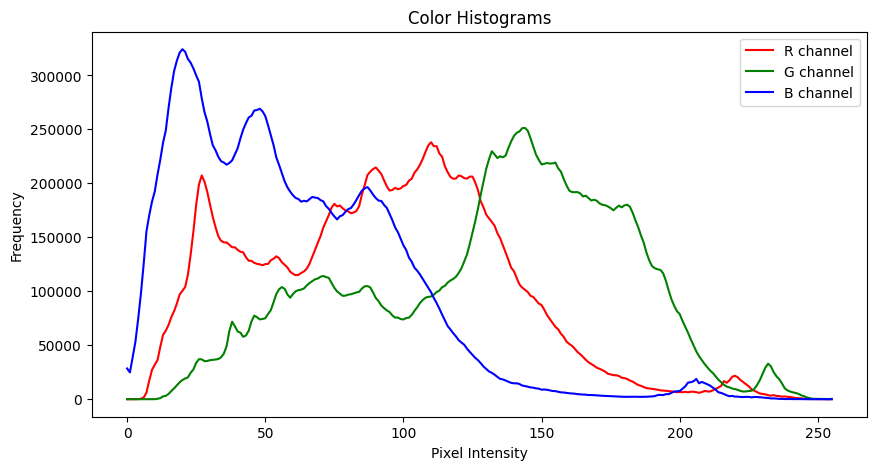

Feature size per channel: 256


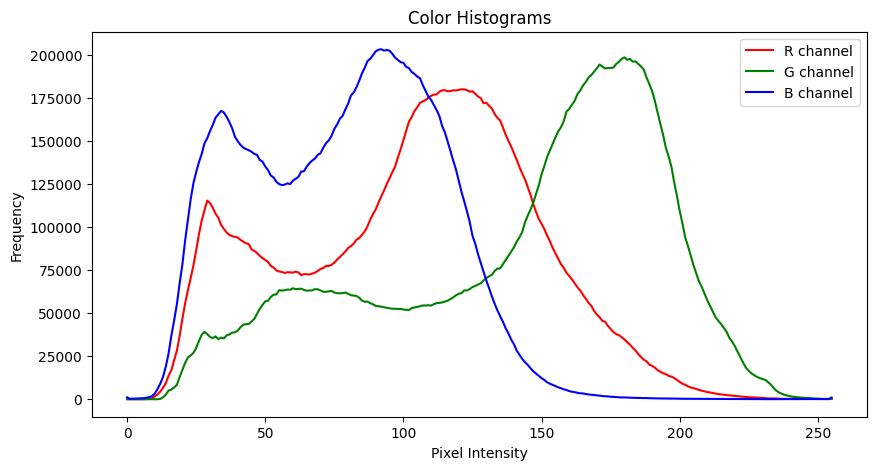

Feature size per channel: 256


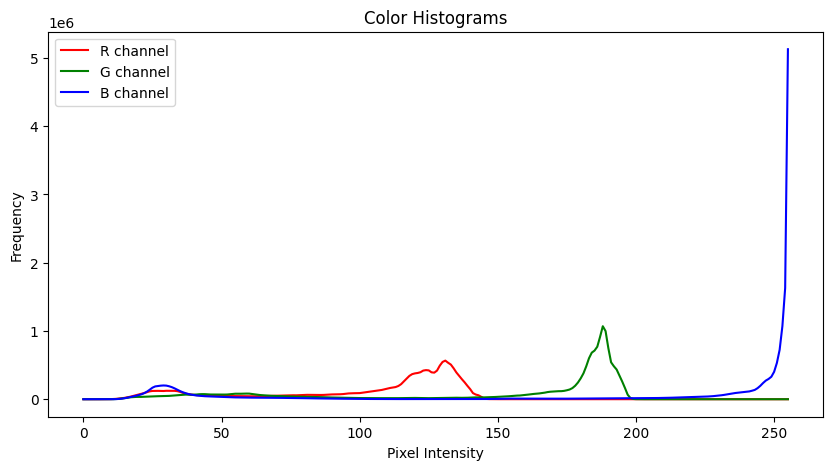

Feature size per channel: 256


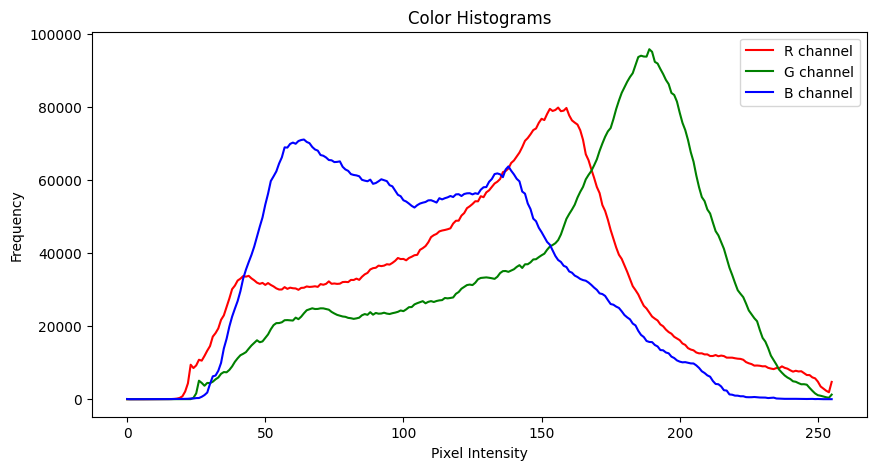

Feature size per channel: 256


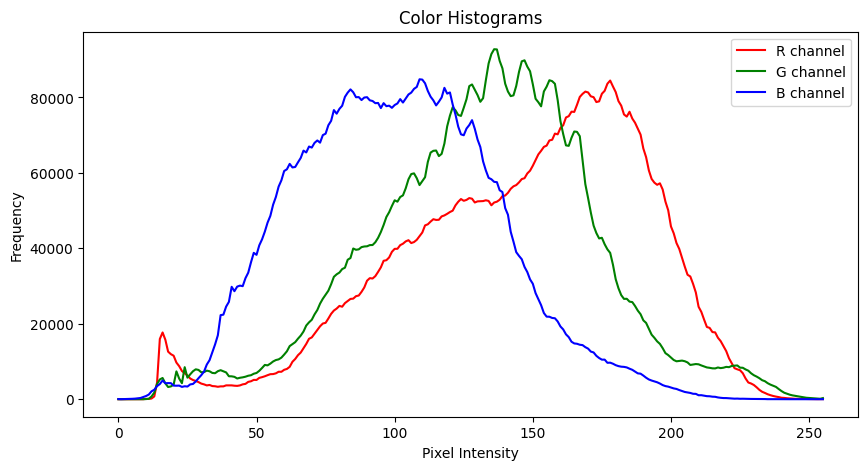

Feature size per channel: 256


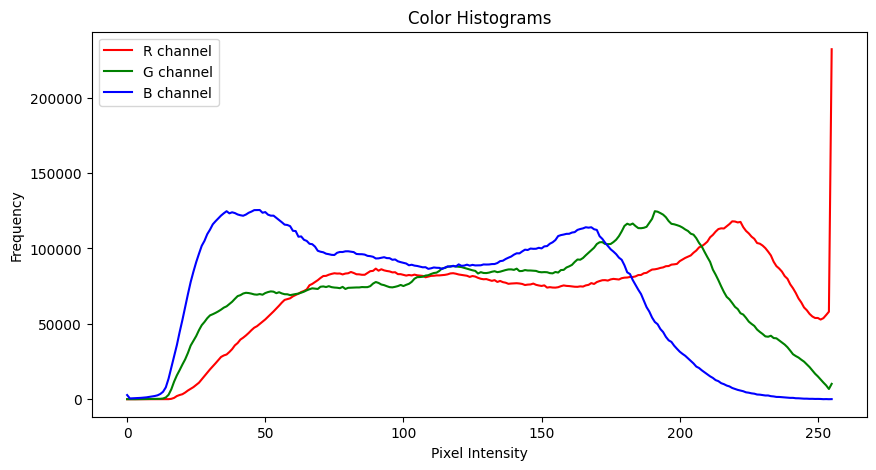

Feature size per channel: 256


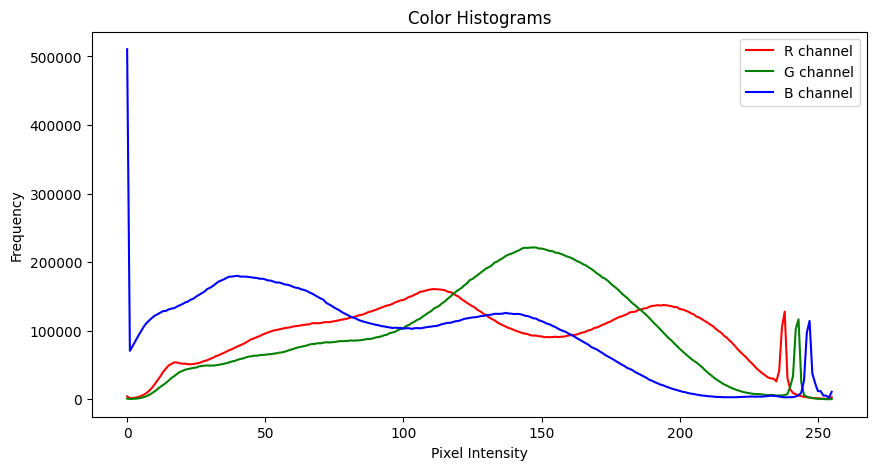

Feature size per channel: 256


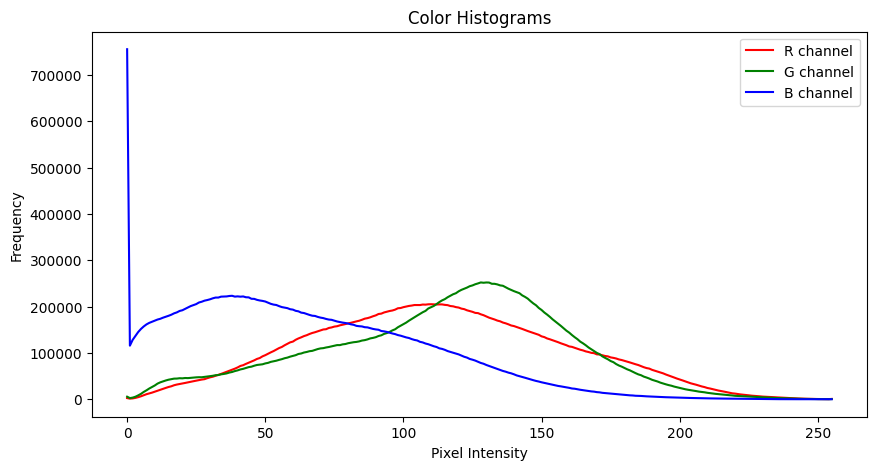

Feature size per channel: 256


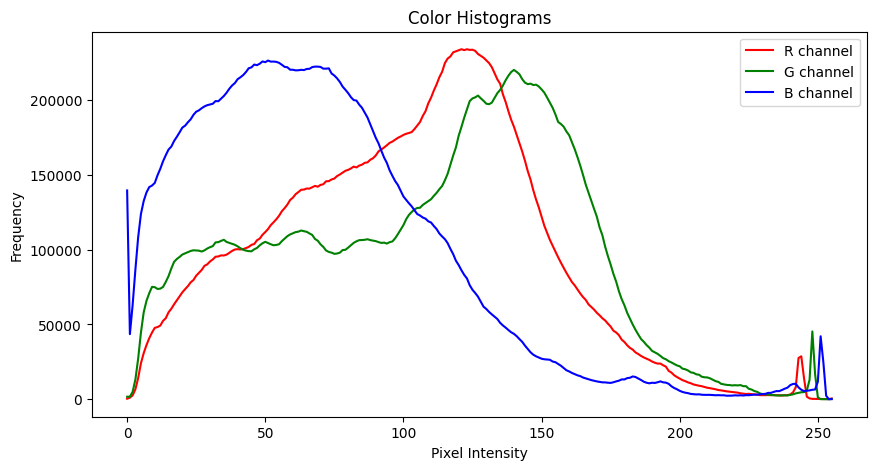

Feature size per channel: 256


In [25]:
# Compute Color Histogram for 10 sample image
for image_file_path in random.choices(image_files_path, k=10):
  image_ch = cv2.imread(image_file_path)
  image_ch = cv2.cvtColor(image_ch, cv2.COLOR_BGR2RGB)  # Convert to RGB

  # Compute histograms for each channel
  colors = ('r', 'g', 'b')
  histograms = []
  for i, color in enumerate(colors):
      hist = cv2.calcHist([image_ch], [i], None, [256], [0, 256])
      histograms.append(hist)

  # Plot histograms
  image_name = image_files_path[0].split("/")[15].split(".")[0]
  plt.figure(figsize=(10, 5))
  for i, (hist, color) in enumerate(zip(histograms, colors)):
      plt.plot(hist, color=color, label=f'{color.upper()} channel')
  plt.title(f"Color Histograms for {image_name}")
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

  # Print feature size
  print(f'Feature size per channel: {histograms[0].size}')

####Edge Detection (Canny)

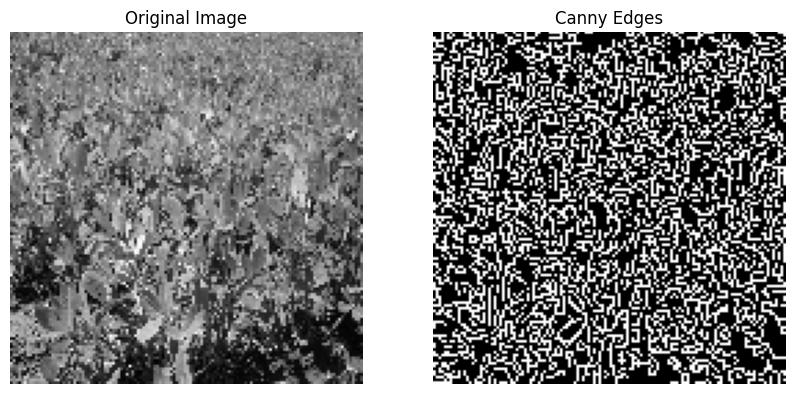

Number of edge pixels: 5781


In [ ]:
# Edge Detection for 10 sample image
for image_file_path in random.choices(image_files_path, k=10):
  image_ed = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
  image_ed = cv2.resize(image_ed, (128, 128))

  # Apply Canny edge detection
  edges = cv2.Canny(image_ed, 100, 200)  # Thresholds for hysteresis

  # Visualize
  print(f'Image: {edge_count}')
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(image_ed, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(edges, cmap='gray')
  plt.title('Canny Edges')
  plt.axis('off')

  plt.show()

  # Feature representation (e.g., edge pixel count)
  edge_count = np.sum(edges > 0)
  print(f'Number of edge pixels: {edge_count}')

####Haralick Texture Features

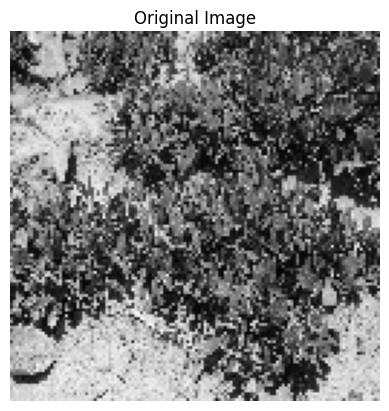

Contrast: 0.0001
Correlation: 3916.7444
Variance: 0.5896
Inverse Diff Moment: 4772.3647
Sum Average: 0.0391
Sum Variance: 224.3730
Sum Entropy: 15172.7144
Entropy: 8.7386
Diff Variance: 14.0949
Diff Entropy: 0.0000
Info Measure 1: 6.8913
Info Measure 2: -0.1892
Max Corr Coeff: 0.9733


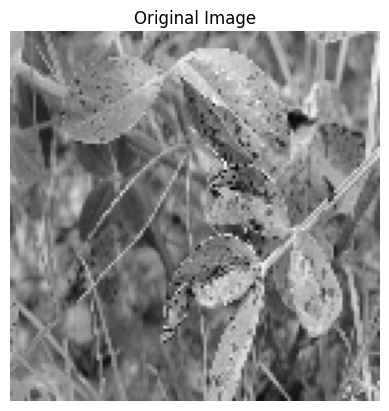

Contrast: 0.0002
Correlation: 740.4582
Variance: 0.7108
Inverse Diff Moment: 1280.2935
Sum Average: 0.0828
Sum Variance: 269.7156
Sum Entropy: 4380.7159
Entropy: 8.0646
Diff Variance: 13.0880
Diff Entropy: 0.0001
Info Measure 1: 5.6265
Info Measure 2: -0.1792
Max Corr Coeff: 0.9594


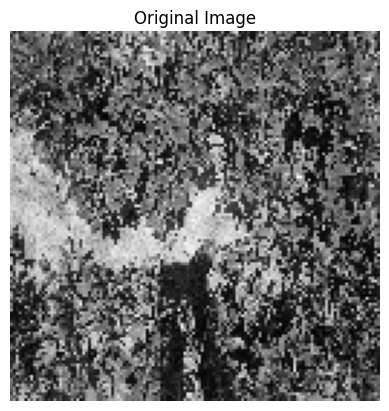

Contrast: 0.0001
Correlation: 4181.7111
Variance: 0.4327
Inverse Diff Moment: 3685.7994
Sum Average: 0.0375
Sum Variance: 190.9369
Sum Entropy: 10561.4865
Entropy: 8.5733
Diff Variance: 14.0527
Diff Entropy: 0.0000
Info Measure 1: 6.9555
Info Measure 2: -0.1643
Max Corr Coeff: 0.9586


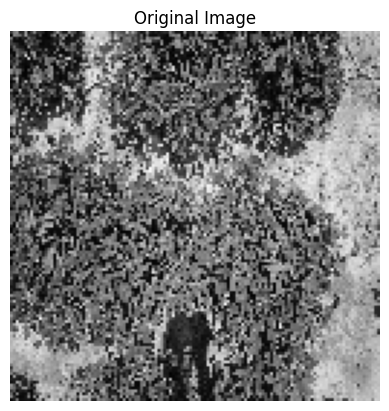

Contrast: 0.0001
Correlation: 3935.4365
Variance: 0.4519
Inverse Diff Moment: 3590.2957
Sum Average: 0.0342
Sum Variance: 214.3770
Sum Entropy: 10425.7464
Entropy: 8.6091
Diff Variance: 14.1346
Diff Entropy: 0.0000
Info Measure 1: 6.9348
Info Measure 2: -0.1667
Max Corr Coeff: 0.9609


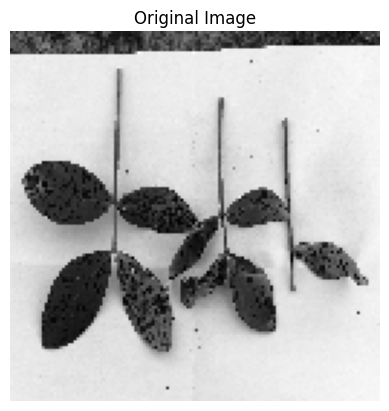

Contrast: 0.0026
Correlation: 530.0369
Variance: 0.9088
Inverse Diff Moment: 2905.9706
Sum Average: 0.2885
Sum Variance: 282.0134
Sum Entropy: 11093.8456
Entropy: 7.3452
Diff Variance: 10.4499
Diff Entropy: 0.0006
Info Measure 1: 4.1761
Info Measure 2: -0.3540
Max Corr Coeff: 0.9943


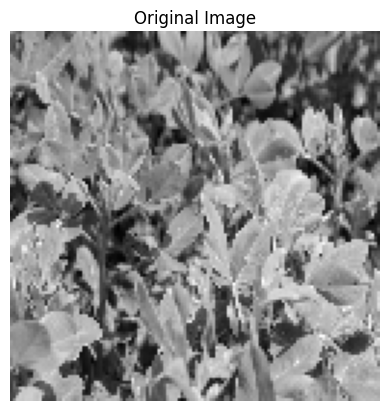

Contrast: 0.0001
Correlation: 1106.4926
Variance: 0.7170
Inverse Diff Moment: 1955.0650
Sum Average: 0.0766
Sum Variance: 276.2065
Sum Entropy: 6713.7675
Entropy: 8.2259
Diff Variance: 13.2937
Diff Entropy: 0.0001
Info Measure 1: 5.8774
Info Measure 2: -0.1820
Max Corr Coeff: 0.9631


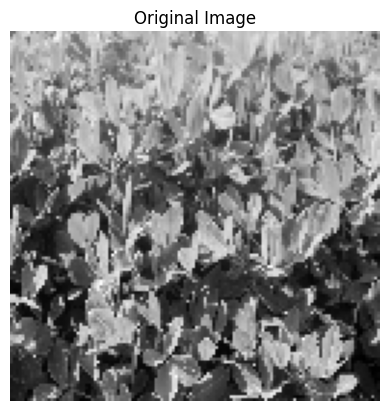

Contrast: 0.0001
Correlation: 1750.4521
Variance: 0.7105
Inverse Diff Moment: 3023.4874
Sum Average: 0.0784
Sum Variance: 262.1929
Sum Entropy: 10343.4975
Entropy: 8.5008
Diff Variance: 13.5963
Diff Entropy: 0.0001
Info Measure 1: 6.1420
Info Measure 2: -0.2027
Max Corr Coeff: 0.9755


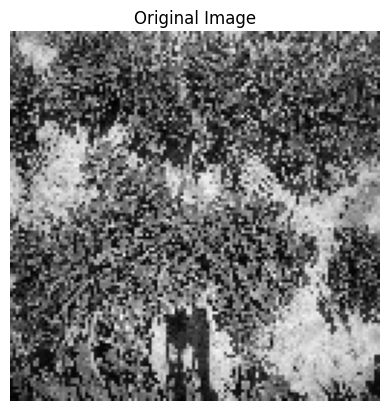

Contrast: 0.0001
Correlation: 4100.1245
Variance: 0.4551
Inverse Diff Moment: 3761.9400
Sum Average: 0.0344
Sum Variance: 209.4105
Sum Entropy: 10947.6357
Entropy: 8.6084
Diff Variance: 14.1505
Diff Entropy: 0.0000
Info Measure 1: 6.9651
Info Measure 2: -0.1664
Max Corr Coeff: 0.9608


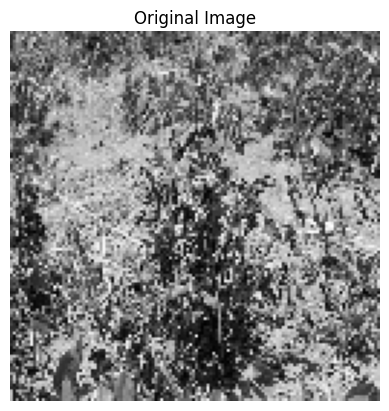

Contrast: 0.0001
Correlation: 3852.6000
Variance: 0.4428
Inverse Diff Moment: 3456.9188
Sum Average: 0.0304
Sum Variance: 253.1825
Sum Entropy: 9975.0753
Entropy: 8.5806
Diff Variance: 14.1920
Diff Entropy: 0.0000
Info Measure 1: 6.9454
Info Measure 2: -0.1655
Max Corr Coeff: 0.9605


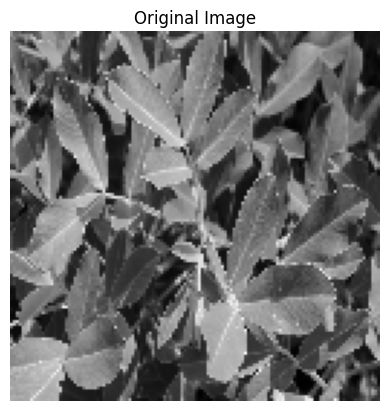

Contrast: 0.0002
Correlation: 1044.0049
Variance: 0.7539
Inverse Diff Moment: 2121.4603
Sum Average: 0.1115
Sum Variance: 212.1849
Sum Entropy: 7441.8362
Entropy: 8.3618
Diff Variance: 13.1798
Diff Entropy: 0.0001
Info Measure 1: 5.6456
Info Measure 2: -0.2267
Max Corr Coeff: 0.9818


In [26]:
# Heralick Texture Features for 10 sample image
for image_file_path in random.choices(image_files_path, k=10):
  image_htf = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
  image_htf = cv2.resize(image_htf, (128, 128))

  # Compute Haralick features
  features = mahotas.features.haralick(image_htf).mean(axis=0)

  # Visualize the original image
  plt.imshow(image_htf, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')
  plt.show()

  # Print features (13 Haralick descriptors)
  feature_names = ['Contrast', 'Correlation', 'Variance', 'Inverse Diff Moment',
                  'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy',
                  'Diff Variance', 'Diff Entropy', 'Info Measure 1', 'Info Measure 2', 'Max Corr Coeff']
  for name, value in zip(feature_names, features):
      print(f'{name}: {value:.4f}')

###Deep Learning Feature Extraction

####Convolutional Neural Networks (CNNs) - VGG16

In [27]:
# Load VGG16 model
# For classification (with top layers)
model_with_top = VGG16(weights='imagenet', include_top=True)

# For feature extraction (without top layers, using the last convolutional layer)
model_without_top = VGG16(weights='imagenet', include_top=False)

# Parameters
IMG_SIZE = (224, 224)  # VGG16 input size

# Dictionary to store results
predictions = {}
features = {}

# Process for random 10 image
for image_file_path in random.choices(image_files_path, k=10):
    # Load and preprocess image
    # img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(image_file_path)
    if img is None:
        print(f"Failed to load {image_file_path}")
        continue

    # Convert BGR (OpenCV) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to 224x224
    img_resized = cv2.resize(img, IMG_SIZE)

    # Convert to array and add batch dimension
    img_array = img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)

    # Apply VGG16 preprocessing (normalization)
    img_array = preprocess_input(img_array)

    # Option 1: Classification (predict ImageNet classes)
    preds = model_with_top.predict(img_array)
    decoded_preds = decode_predictions(preds, top=3)[0]  # Top 3 predictions
    image_name = image_file_path.split("/")[15].split(".")[0]
    print(image_name)
    predictions[image_name] = decoded_preds

    # Option 2: Feature extraction (last convolutional layer output)
    feat = model_without_top.predict(img_array)
    # Flatten the features (e.g., shape (1, 7, 7, 512) -> (1, 7*7*512))
    feat = feat.flatten()
    features[image_name] = feat

    # print(f"Processed {image_name}")



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DSC05686_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
DSC06885_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
DSC09774_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
DSC05757_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
IMG_8354_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
DSC06889_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
IMG_7329_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
DSC05659_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
DSC05626_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
DSC05757_JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148

In [28]:
# Print classification results
print("\n=== Classification Results ===")
for image_file, pred in predictions.items():
    print(f"\nImage: {image_file}")
    for i, (class_id, class_name, prob) in enumerate(pred):
        print(f"  {i+1}. {class_name}: {prob*100:.2f}%")


=== Classification Results ===

Image: DSC05686_JPG
  1. park_bench: 4.72%
  2. picket_fence: 4.05%
  3. maze: 2.19%

Image: DSC06885_JPG
  1. walking_stick: 19.63%
  2. green_lizard: 5.20%
  3. bell_pepper: 4.35%

Image: DSC09774_JPG
  1. pot: 94.26%
  2. doormat: 4.02%
  3. patio: 0.15%

Image: DSC05757_JPG
  1. cliff_dwelling: 19.61%
  2. stone_wall: 13.61%
  3. cliff: 8.21%

Image: IMG_8354_JPG
  1. hip: 18.38%
  2. fig: 7.77%
  3. acorn: 7.68%

Image: DSC06889_JPG
  1. green_lizard: 8.09%
  2. American_chameleon: 5.56%
  3. walking_stick: 4.94%

Image: IMG_7329_JPG
  1. acorn: 32.17%
  2. African_chameleon: 6.92%
  3. tailed_frog: 4.85%

Image: DSC05659_JPG
  1. sandbar: 5.44%
  2. African_elephant: 4.62%
  3. stone_wall: 4.05%

Image: DSC05626_JPG
  1. maze: 66.11%
  2. stone_wall: 7.96%
  3. head_cabbage: 2.14%


In [29]:
# Print feature shapes
print("\n=== Feature Extraction Results ===")
for image_file, feat in features.items():
  print(f"{image_file}: Feature shape = {feat.shape}")


=== Feature Extraction Results ===
DSC05686_JPG: Feature shape = (25088,)
DSC06885_JPG: Feature shape = (25088,)
DSC09774_JPG: Feature shape = (25088,)
DSC05757_JPG: Feature shape = (25088,)
IMG_8354_JPG: Feature shape = (25088,)
DSC06889_JPG: Feature shape = (25088,)
IMG_7329_JPG: Feature shape = (25088,)
DSC05659_JPG: Feature shape = (25088,)
DSC05626_JPG: Feature shape = (25088,)


In [ ]:
# Optional: Visualize an example image with its predictions

if predictions:
  image_files_path_random = random.sample(image_files_path,10)
  for image_file_path in image_files_path_random:
    # image_file_path = image_files_path[10]
    example_image = cv2.imread(image_file_path)
    example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)
    plt.imshow(example_image)
    image_name = image_file_path.split("/")[15].split(".")[0]
    plt.title(f"Predictions for {image_name}:\n{predictions.get(image_name)}")
    plt.axis('off')
    plt.show()

####Autoencoders

Loaded 192 images with shape (64, 64, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,438,273 (9.30 MB)

 Trainable params: 2,438,273 (9.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step - loss: 0.6929 - val_loss: 0.6923
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 635ms/step - loss: 0.6917 - val_loss: 0.6908
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 962ms/step - loss: 0.6900 - val_loss: 0.6901
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 659ms/step - loss: 0.6902 - val_loss: 0.6903
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - loss: 0.6901 - val_loss: 0.6901
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 893ms/step - loss: 0.6888 - val_loss: 0.6900
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 655ms/step - loss: 0.6895 - val_loss: 0.6902
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 638ms/step - loss: 0.6904 - val_loss: 0.6901
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 847ms/step - loss: 0.6895 - val_loss: 0.6901
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 843ms/step - loss: 0.6891 - val_loss: 0.6899
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step - loss: 0.6891 - val_loss: 0.6899
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - loss: 0.6873 - val_lo

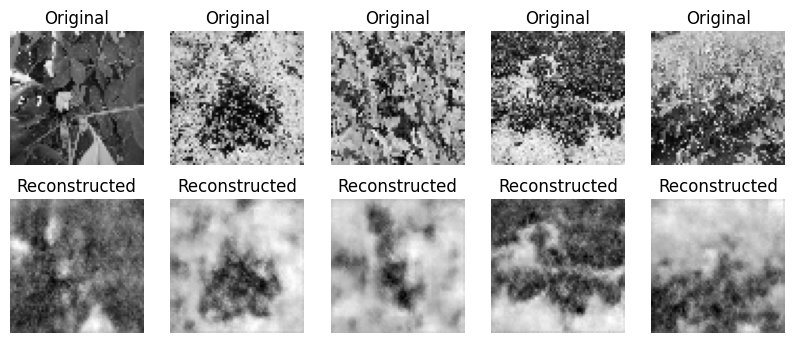


=== Latent Feature Shapes ===
Image 0: Latent feature shape = (128,)
Image 1: Latent feature shape = (128,)
Image 2: Latent feature shape = (128,)
Image 3: Latent feature shape = (128,)
Image 4: Latent feature shape = (128,)
Image 5: Latent feature shape = (128,)
Image 6: Latent feature shape = (128,)
Image 7: Latent feature shape = (128,)
Image 8: Latent feature shape = (128,)
Image 9: Latent feature shape = (128,)
Image 10: Latent feature shape = (128,)
Image 11: Latent feature shape = (128,)
Image 12: Latent feature shape = (128,)
Image 13: Latent feature shape = (128,)
Image 14: Latent feature shape = (128,)
Image 15: Latent feature shape = (128,)
Image 16: Latent feature shape = (128,)
Image 17: Latent feature shape = (128,)
Image 18: Latent feature shape = (128,)
Image 19: Latent feature shape = (128,)
Image 20: Latent feature shape = (128,)
Image 21: Latent feature shape = (128,)
Image 22: Latent feature shape = (128,)
Image 23: Latent feature shape = (128,)
Image 24: Latent fe

In [ ]:
# Parameters
IMG_SIZE = (64, 64)  # Resize images to this size (adjust based on your needs)
BATCH_SIZE = 32
EPOCHS = 50
LATENT_DIM = 128  # Size of the latent space

# Step 1: Load and preprocess images
def load_and_preprocess_images(image_files_path, img_size):
    images = []
    for image_file_path in image_files_path:
        # img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is None:
            print(f"Failed to load {image_file_path}")
            continue
        img = cv2.resize(img, img_size)  # Resize to IMG_SIZE
        img = img.astype('float32') / 255.0  # Normalize to [0, 1]
        images.append(img)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension (for grayscale)
    return images

# Load images
images = load_and_preprocess_images(image_files_path, IMG_SIZE)
print(f"Loaded {images.shape[0]} images with shape {images.shape[1:]}")

# Step 2: Define the autoencoder architecture
def build_autoencoder(img_shape, latent_dim):
    # Encoder
    input_img = layers.Input(shape=img_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten and create latent space
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(8 * 8 * 128, activation='relu')(latent)  # Match shape after last max pooling
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # Encoder model (for feature extraction)
    encoder = models.Model(input_img, latent)

    return autoencoder, encoder

# Build the autoencoder
img_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)  # Grayscale: (height, width, 1)
autoencoder, encoder = build_autoencoder(img_shape, LATENT_DIM)
autoencoder.summary()

# Step 3: Train the autoencoder
autoencoder.fit(images, images,  # Input and target are the same (reconstruction)
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_split=0.2)

# Step 4: Use the autoencoder for reconstruction and feature extraction
# Reconstruct images
reconstructed = autoencoder.predict(images)

# Extract latent features
latent_features = encoder.predict(images)

# Step 5: Visualize some results
n = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

# Print latent feature shapes for 10 random features
print("\n=== Latent Feature Shapes ===")
for i, feat in random.choice(enumerate(latent_features), k=10):
    print(f"Image {i}: Latent feature shape = {feat.shape}")

####Transfer Learning - ResNet50

In [15]:
# Parameters
IMG_SIZE = (224, 224)  # ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 2

def load_and_preprocess_image(img_path, img_size):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, img_size)  # Resize to 224x224
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Apply ResNet50 preprocessing
    return img_array

# Feature Extraction
# Load ResNet50 without top layers for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')  # Global average pooling

# Dictionary to store features
features = {}

# Extract features for each image
for image_file_path in image_files_path:
    # img_path = os.path.join(image_dir, image_file)
    img_array = load_and_preprocess_image(image_file_path, IMG_SIZE)
    if img_array is None:
        print(f"Failed to load {image_file_path}")
        continue

    # Extract features
    image_name = image_file_path.split("/")[15].split(".")[0]
    feat = base_model.predict(img_array)
    features[image_name] = feat.flatten()  # Flatten to 1D vector (2048 dimensions)
    # print(f"Extracted features for {image_name}: shape = {feat.shape}")

# Print feature shapes for 10 random images
print("\n=== Feature Extraction Results ===")
for image_file, feat in features.items():
    print(f"{image_file}: Feature shape = {feat.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━

##Training Machine Learning Models

###Traditional models

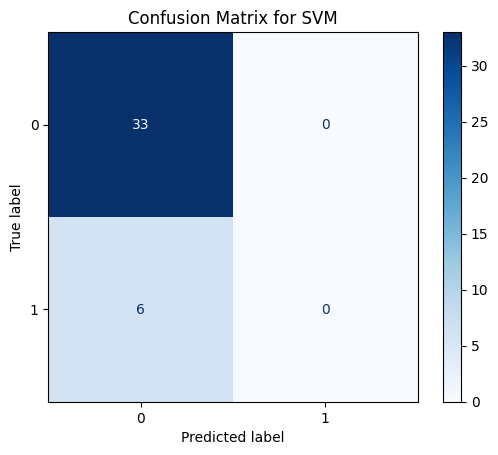

SVM Accuracy: 0.8462
              precision    recall  f1-score   support

    Diseased       0.85      1.00      0.92        33
     Healthy       0.00      0.00      0.00         6

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


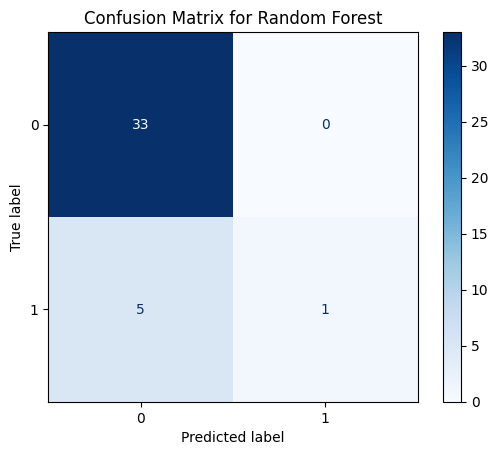

Random Forest Accuracy: 0.8718
              precision    recall  f1-score   support

    Diseased       0.87      1.00      0.93        33
     Healthy       1.00      0.17      0.29         6

    accuracy                           0.87        39
   macro avg       0.93      0.58      0.61        39
weighted avg       0.89      0.87      0.83        39



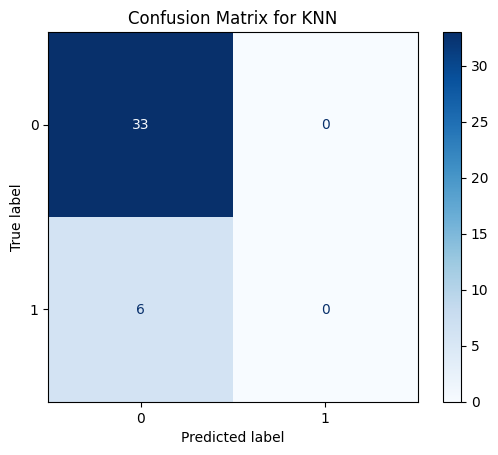

KNN Accuracy: 0.8462
              precision    recall  f1-score   support

    Diseased       0.85      1.00      0.92        33
     Healthy       0.00      0.00      0.00         6

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


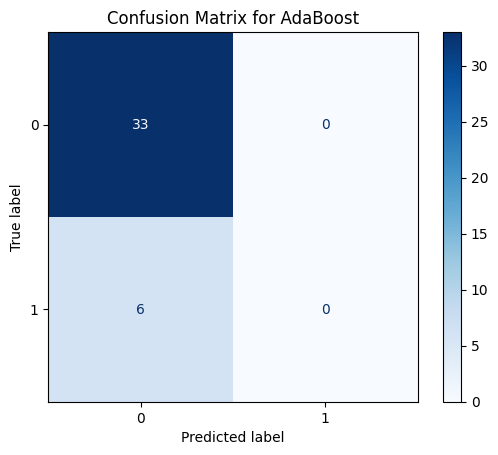

AdaBoost Accuracy: 0.8462
              precision    recall  f1-score   support

    Diseased       0.85      1.00      0.92        33
     Healthy       0.00      0.00      0.00         6

    accuracy                           0.85        39
   macro avg       0.42      0.50      0.46        39
weighted avg       0.72      0.85      0.78        39



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


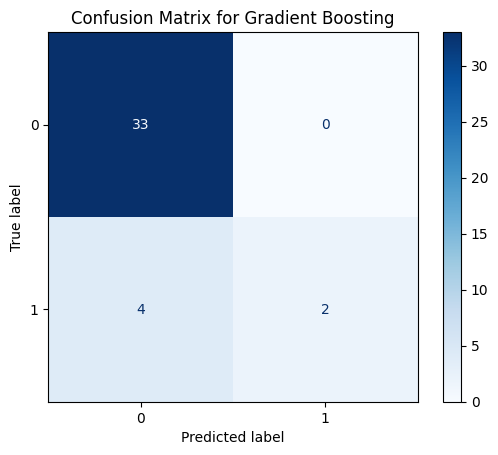

Gradient Boosting Accuracy: 0.8974
              precision    recall  f1-score   support

    Diseased       0.89      1.00      0.94        33
     Healthy       1.00      0.33      0.50         6

    accuracy                           0.90        39
   macro avg       0.95      0.67      0.72        39
weighted avg       0.91      0.90      0.87        39



In [5]:
# Step 1: Synthetic Dataset Preparation (Replace with your real dataset)
def load_and_extract_hog(image_path, label, size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True)
    return hog_features, label

features, labels = [], []
for path in diseased_images:
  label = "Diseased"
  feat, lbl = load_and_extract_hog(path, label)
  features.append(feat)
  labels.append(lbl)

for path in healthy_images:
  label = "Healthy"
  feat, lbl = load_and_extract_hog(path, label)
  features.append(feat)
  labels.append(lbl)

X = np.array(features)
y = np.array(labels)

# Step 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define and Train Models
training_models = {
    'SVM': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

results = {}
for name, model in training_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm);
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for ' + name)
    plt.show()

    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))



###ResNet50

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Found 155 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.6854 - loss: 1.0252 - val_accuracy: 0.8378 - val_loss: 0.4822
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8949 - loss: 0.2899 - val_accuracy: 0.8378 - val_loss: 0.3932
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9239 - loss: 0.1920 - val_accuracy: 0.8378 - val_loss: 0.3540
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9276 - loss: 0.1314 - val_accuracy: 0.8649 - val_loss: 0.3094
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8987 - loss: 0.1776 - val_accuracy: 0.9189 - val_loss: 0.3194
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9208 - loss: 0.1454 - val_accuracy: 0.8108 - val_loss: 0.3365
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9384 - loss: 0.1480 - val_accuracy: 0.8108 - val_loss: 0.3642
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9103 - loss: 0.1643 - val_accuracy: 0.8378 - val_loss: 0.3160
Epoch 9/

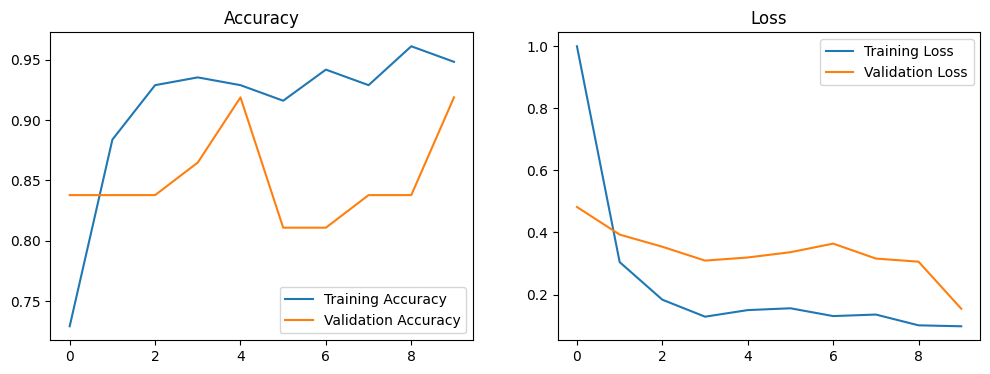

In [7]:
dataset_dir = "/content/drive/MyDrive/Personal/Masters/Msc Comp Sc - MUK/Year 1/Sem 2/MCS 7224 Computer Vision/Assignment 3/model/images/train/"

# Parameters
IMG_SIZE = (224, 224)  # ResNet50 input size
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 2

# Fine-Tuning for Classification
# Check if dataset directory exists and contains subdirectories (classes)
if os.path.exists(dataset_dir) and len([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]) > 0:
    # Load ResNet50 without top layers
    base_model_finetune = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    base_model_finetune.trainable = False

    # Add custom layers on top
    model = models.Sequential([
        base_model_finetune,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Data generators for training and validation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    # Train the model (initial training with frozen layers)
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator
    )

    # Unfreeze some layers and fine-tune
    base_model_finetune.trainable = True
    for layer in base_model_finetune.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history_finetune = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
else:
    print("No labeled dataset provided for fine-tuning. Skipping fine-tuning section.")


####Use the fine-tuned model to predict on new images

In [20]:
# Predict on random 20 images
if 'model' in locals():
  for image_file_path in random.choices(image_files_path, k=20):
    image_class = image_file_path.split("/")[14]
    img_array = load_and_preprocess_image(image_file_path, IMG_SIZE)
    if img_array is None:
        continue
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred, axis=1)
    predicted_class = "Diseased" if predicted_class[0] == 0 else "Healthy"
    print(f"Image {image_file}: Predicted class = {predicted_class} : Actual class = {image_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Image DSC05879_JPG: Predicted class = Healthy : Actual class = Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Diseased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Image DSC05879_JPG: Predicted class = Diseased : Actual class = Dise

###CNN

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7610 - loss: 0.7510 - val_accuracy: 0.8205 - val_loss: 0.4102
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8098 - loss: 0.4155 - val_accuracy: 0.8462 - val_loss: 0.4158
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9433 - loss: 0.2600 - val_accuracy: 0.8462 - val_loss: 0.3491
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9393 - loss: 0.2409 - val_accuracy: 0.8462 - val_loss: 0.5374
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9261 - loss: 0.2513 - val_accuracy: 0.8718 - val_loss: 0.3152
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9709 - loss: 0.1103 - val_accuracy: 0.8462 - val_loss: 0.3635
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9962 - loss: 0.0255 - val_accuracy: 0.8462 - val_loss: 0.4283
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9991 - loss: 0.0171 - val_accuracy: 0.8462 - val_loss: 0.

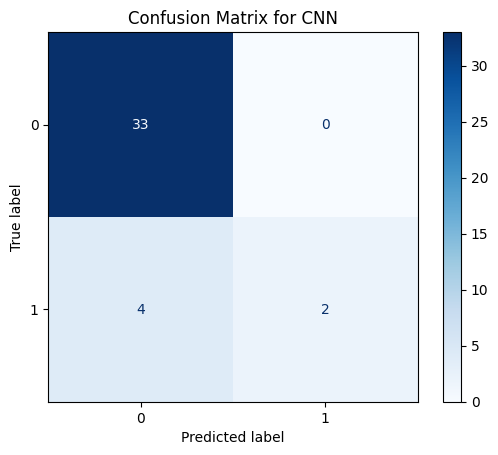

In [9]:
# For CNN we use raw images, not HOG features.
images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path  in diseased_images + healthy_images]
images = [cv2.resize(img, (128, 128)) for img in images]
X_images = np.array(images).reshape(-1, 128, 128, 1) / 255.0  # Normalize

# Convert labels to numerical representation (0 for 'Diseased', 1 for 'Healthy')
y_images = np.where(y == 'Diseased', 0, 1)

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_images, y_images, test_size=0.2, random_state=42)

cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_img, y_train_img, epochs=10, batch_size=2, validation_data=(X_test_img, y_test_img), verbose=1)
cnn_loss, cnn_acc = cnn.evaluate(X_test_img, y_test_img)
results['CNN'] = cnn_acc
print(f'CNN Accuracy: {cnn_acc:.4f}')

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm);
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')
plt.show()

###VGG16

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.6780 - loss: 0.7670 - val_accuracy: 0.8718 - val_loss: 0.3300
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.9582 - loss: 0.1169 - val_accuracy: 0.9487 - val_loss: 0.2281
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9880 - loss: 0.0699 - val_accuracy: 0.9231 - val_loss: 0.2264
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 0.9487 - val_loss: 0.2160
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.9231 - val_loss: 0.2277
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step - accuracy: 0.9279 - loss: 0.2326
VGG16 Accuracy: 0.9231


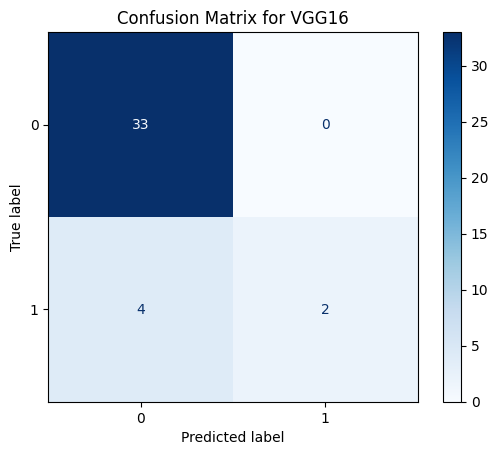

In [10]:
# Load images for VGG16 (RGB, 224x224)
vgg_images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in diseased_images + healthy_images]
vgg_images = [cv2.resize(img, (224, 224)) for img in vgg_images]
X_vgg = np.array(vgg_images)
X_vgg = tf.keras.applications.vgg16.preprocess_input(X_vgg)
# y_vgg = y
y_vgg = np.where(y == 'Diseased', 0, 1)

X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg, test_size=0.2, random_state=42)

base_model = VGG16(weights='imagenet', include_top=False)
vgg_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
base_model.trainable = False  # Freeze base layers
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.fit(X_train_vgg, y_train_vgg, epochs=5, batch_size=2, validation_data=(X_test_vgg, y_test_vgg), verbose=1)
vgg_loss, vgg_acc = vgg_model.evaluate(X_test_vgg, y_test_vgg)
results['VGG16'] = vgg_acc
print(f'VGG16 Accuracy: {vgg_acc:.4f}')

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm);
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for VGG16')
plt.show()

###Performance Analysis

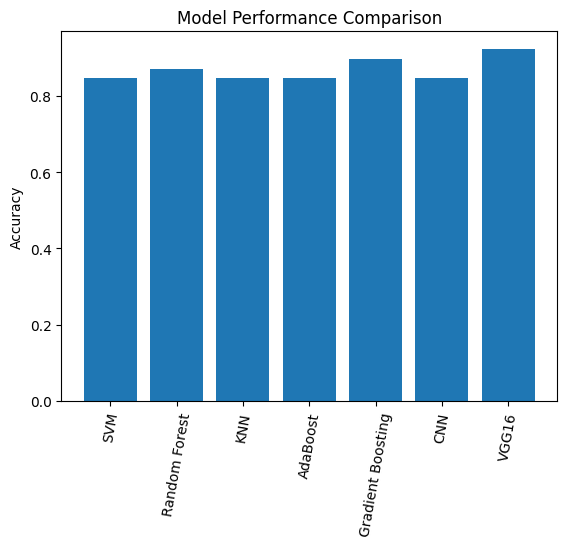

In [21]:
plt.bar(results.keys(), results.values())
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=80)
plt.show()

###Findings
The deep learning methods performed best